## KMeans Clustering

In this script, we will:

1. Load and preprocess the dataset.
2. Perform KMeans clustering.
3. Evaluate clustering using Silhouette Score and Adjusted Rand Index (ARI).
4. Visualize cluster-label relationships using heatmaps.

In [1]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.impute import SimpleImputer

### Task 1: Load the CSV file, define relevant groups, and create dataframes

We will categorize the columns into audio features and video features to enable more detailed analysis later in the script.

In [2]:
# Load CSV
df = pd.read_csv("../ravdess_processed_data/combined_summary_updated.csv") 

# Define columns
general_info_cols = ["id", "sex", "condition"]

audio_feature_cols = [
    "f0_mean","f0_stddev","f0_range","f1_mean","f1_stddev","f1_range",
    "f2_mean","f2_stddev","f2_range","f3_mean","f3_stddev","f3_range",
    "f4_mean","f4_stddev","f4_range","loudness_mean","loudness_stddev","loudness_range",
    "hnr_mean","hnr_stddev","hnr_range","jitter","jitter_abs","jitter_rap","jitter_ppq5",
    "jitter_ddp","shimmer","shimmer_db","shimmer_apq3","shimmer_apq5","shimmer_apq11",
    "shimmer_dda","gne_ratio","mfcc1_mean","mfcc2_mean","mfcc3_mean","mfcc4_mean","mfcc5_mean",
    "mfcc6_mean","mfcc7_mean","mfcc8_mean","mfcc9_mean","mfcc10_mean","mfcc11_mean","mfcc12_mean",
    "mfcc13_mean","mfcc14_mean","mfcc1_var","mfcc2_var","mfcc3_var","mfcc4_var","mfcc5_var",
    "mfcc6_var","mfcc7_var","mfcc8_var","mfcc9_var","mfcc10_var","mfcc11_var","mfcc12_var",
    "mfcc13_var","mfcc14_var","cpp_mean","cpp_var","spir","dur_med","dur_mad","silence_ratio",
    "rel_f0_sd","rel_se0_sd"
]

video_feature_cols = [
    "anger_mean","disgust_mean","fear_mean","happiness_mean","sadness_mean","surprise_mean",
    "neutral_mean","AU01_mean","AU02_mean","AU04_mean","AU05_mean","AU06_mean","AU07_mean",
    "AU09_mean","AU10_mean","AU11_mean","AU12_mean","AU14_mean","AU15_mean","AU17_mean",
    "AU20_mean","AU23_mean","AU24_mean","AU25_mean","AU26_mean","AU28_mean","AU43_mean",
    "mouth_openness_mean","anger_std","disgust_std","fear_std","happiness_std","sadness_std",
    "surprise_std","neutral_std","AU01_std","AU02_std","AU04_std","AU05_std","AU06_std","AU07_std",
    "AU09_std","AU10_std","AU11_std","AU12_std","AU14_std","AU15_std","AU17_std","AU20_std",
    "AU23_std","AU24_std","AU25_std","AU26_std","AU28_std","AU43_std","mouth_openness_std"
]

# Create separate DataFrames
audio_df = df[general_info_cols + audio_feature_cols]
video_df = df[general_info_cols + video_feature_cols]
combined_df = df[general_info_cols + audio_feature_cols + video_feature_cols]

### Task 2: Preprocess the data

Follow the steps:

1. Separate features and target (and drop metadata columns)
2. Impute missing values (sklearn - SimpleImputer) - K-Means cannot handle NaN or missing values; distance computations fail if any feature is missing.
3. Scale features (sklearn - StandardScaler) - If features are on different scales, those with larger numerical ranges dominate the distance calculation, which can skew the clusters.

In [ ]:
# TODO: Implement a function for preprocessing data
def preprocess_data(df, target, metadata_cols=["id", "condition","sex"]):
    """
    Preprocess the dataset for modeling - drop metadata columns, separate features and target, impute missing values, and scale features

    Args:
        df (pd.DataFrame): Input dataset
        target_col (str): Name of the target column
        metadata_cols (list, optional): Columns to drop

    Returns:
        X_scaled (np.ndarray): Scaled feature matrix
        y (np.ndarray): target labels
    """

    #return None, None
    
    # Separate target and features
    y = df[target]
    X = df.drop(columns=metadata_cols)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y
    


<details>
<summary><span style="font-size:20px; color:darkgoldenrod; font-weight:bold;">Click to see the solution</span></summary>

```python
def preprocess_data(df, target, metadata_cols=["id", "condition","sex"]):
    """
    Preprocess the dataset for modeling - drop metadata columns, separate features and target, impute missing values, and scale features

    Args:
        df (pd.DataFrame): Input dataset
        target_col (str): Name of the target column
        metadata_cols (list, optional): Columns to drop

    Returns:
        X_scaled (np.ndarray): Scaled feature matrix
        y (np.ndarray): target labels
    """

    # Separate target and features
    y = df[target]
    X = df.drop(columns=metadata_cols)

    # Impute missing values
    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    return X_scaled, y

### Task 3: KMeans Clustering 

Perform KMeans clustering and evaluate the clusters using:

📌 In unsupervised learning, we typically don’t know how many clusters exist in the data, so various methods are used to estimate an appropriate number.

For this exercise, though, we already know the number of labels. So we’ll try using that number as our cluster count and see how well K-Means can group the data. 

Silhouette Score → how well-separated the clusters are (sklearn.metrics - silhouette_score) [-1, 1]

Adjusted Rand Index (ARI) → how well clusters match a known categorical label (sklearn.metrics - adjusted_rand_score) [-1, 1]

In [4]:
# TODO: Implement a function for kmeans clustering
def kmeans_clustering(df, X_scaled, y):
    """
    Perform KMeans clustering on preprocessed features and evaluate against a categorical label

    Args:
        df (pd.DataFrame): Original dataframe containing features and labels
        X_scaled (np.ndarray): Standardized feature matrix
        y (pd.Series): Categorical target labels to compare clusters against

    Returns:
        pd.DataFrame: Copy of the original dataframe with an added 'cluster' column.
    
    Prints:
        Silhouette Score: Measures cluster cohesion (range [-1, 1]).
        Adjusted Rand Index (ARI): Measures agreement between predicted clusters and true labels (range [-1, 1]).
    """

    #return None
    n_clusters = len(y.unique())
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Attach clusters to df copy
    df_out = df.copy()
    df_out["cluster"] = clusters
    
    # Evaluate clustering
    sil_score = silhouette_score(X_scaled, clusters)
    ari_score = adjusted_rand_score(y, clusters)
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")

    return df_out


<details>
<summary><span style="font-size:20px; color:darkgoldenrod; font-weight:bold;">Click to see the solution</span></summary>

```python
def kmeans_clustering(df, X_scaled, y):
    """
    Perform KMeans clustering on preprocessed features and evaluate against a categorical label

    Args:
        df (pd.DataFrame): Original dataframe containing features and labels
        X_scaled (np.ndarray): Standardized feature matrix
        y (pd.Series): Categorical target labels to compare clusters against

    Returns:
        pd.DataFrame: Copy of the original dataframe with an added 'cluster' column.
    
    Prints:
        Silhouette Score: Measures cluster cohesion (range [-1, 1]).
        Adjusted Rand Index (ARI): Measures agreement between predicted clusters and true labels (range [-1, 1]).
    """

   
    n_clusters = len(y.unique())
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Attach clusters to df copy
    df_out = df.copy()
    df_out["cluster"] = clusters
    
    # Evaluate clustering
    sil_score = silhouette_score(X_scaled, clusters)
    ari_score = adjusted_rand_score(y, clusters)
    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")

    return df_out


### Task 4: Cluster Visualization

Visualize the clustering results using a heatmap showing the proportion of each label in each cluster.

In [5]:
def plot_cluster_results(df_out, target_label, dataset_name):
    """
    Plot the clustering results as a heatmap showing the proportion of each label in each cluster.

    Args:
        df_out (pd.DataFrame): DataFrame containing a 'cluster' column and the target label column.
        target_label (str): Name of the categorical label to compare clusters against 
        dataset_name (str): Name of the dataset for labeling the plot title.

    Returns:
        None

    Displays:
        A heatmap showing the proportion of each target label within each cluster.
    """
    try:
        # Heatmap of cluster vs label proportions
        confusion = pd.crosstab(df_out["cluster"], df_out[target_label])
        confusion_norm = confusion.div(confusion.sum(axis=1), axis=0)
        
        plt.figure(figsize=(10, 4))
        sns.heatmap(confusion_norm, annot=True, fmt=".2f", cmap="Blues")
        plt.title(f"{dataset_name}: Cluster vs {target_label} Proportions")
        plt.ylabel("Cluster")
        plt.xlabel(target_label.capitalize())
        plt.show()
    except Exception as e:
        print(f"[Warning] Could not plot")
        print("Most likely the code is not yet complete (complete the cells with TODO).\n")


### Task 5: Apply Clustering to Combined Features

Cluster by condition (emotion) and sex

Silhouette Score: 0.051
Adjusted Rand Index: 0.160


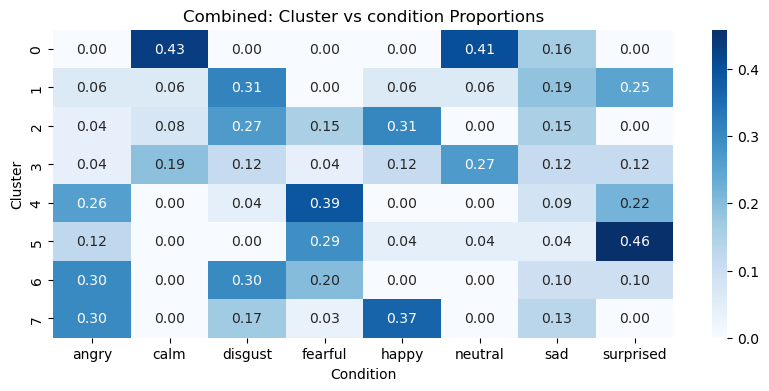

In [6]:
X_emo_combined, y_emo_combined = preprocess_data(combined_df, "condition")
df_out_combined = kmeans_clustering(combined_df, X_emo_combined, y_emo_combined)
plot_cluster_results(df_out_combined, "condition", "Combined")

Silhouette Score: 0.082
Adjusted Rand Index: 0.529


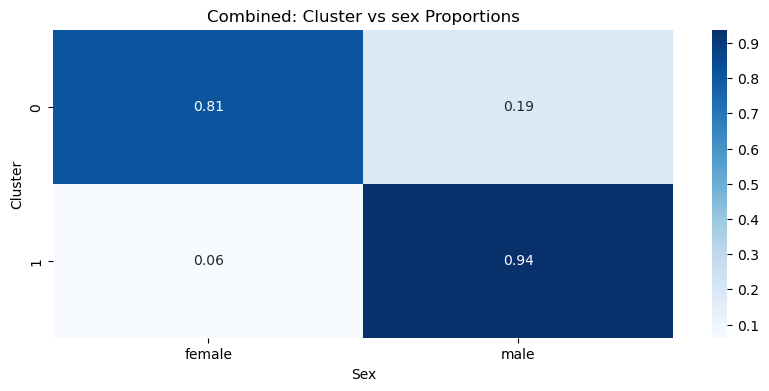

In [7]:
X_sex_combined, y_sex_combined = preprocess_data(combined_df, "sex")
df_out_combined = kmeans_clustering(combined_df, X_sex_combined, y_sex_combined)
plot_cluster_results(df_out_combined, "sex", "Combined")

### Insights?
🕵️ Which clusters appear more consistent with the labels? Next, evaluate if seperating video and audio features can result in better clusters?

### Task 6: Apply Clustering to Video Features

Cluster by condition (emotion) and sex

Silhouette Score: 0.089
Adjusted Rand Index: 0.263


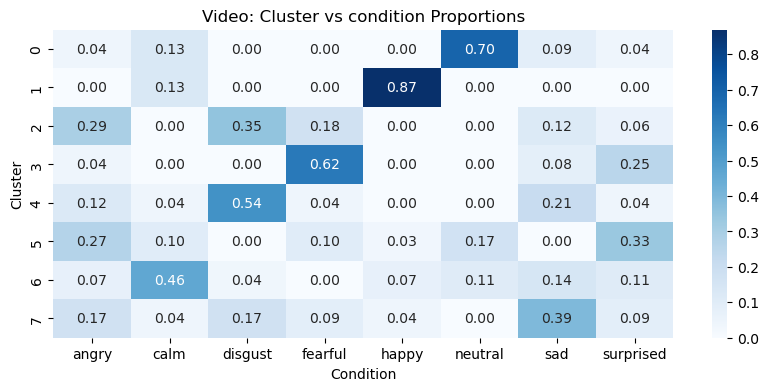

In [8]:
X_emo_video, y_emo_video = preprocess_data(video_df, "condition")
df_out_video = kmeans_clustering(video_df, X_emo_video, y_emo_video)
plot_cluster_results(df_out_video, "condition", "Video")

Silhouette Score: 0.128
Adjusted Rand Index: 0.004


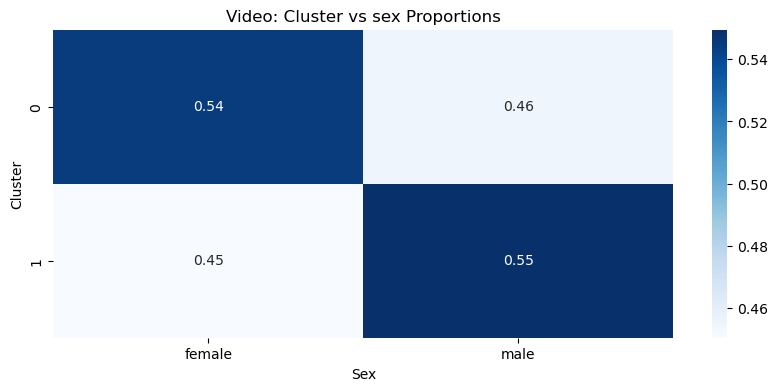

In [9]:
X_sex_video, y_sex_video = preprocess_data(video_df, "sex")
df_out_video = kmeans_clustering(video_df, X_sex_video, y_sex_video)
plot_cluster_results(df_out_video, "sex", "Video")

### Insights?
🤔 Are clusters based on video features better at separating emotions or sex?

### Task 7: Apply Clustering to Audio Features

Cluster by condition (emotion) and sex

Silhouette Score: 0.077
Adjusted Rand Index: 0.083


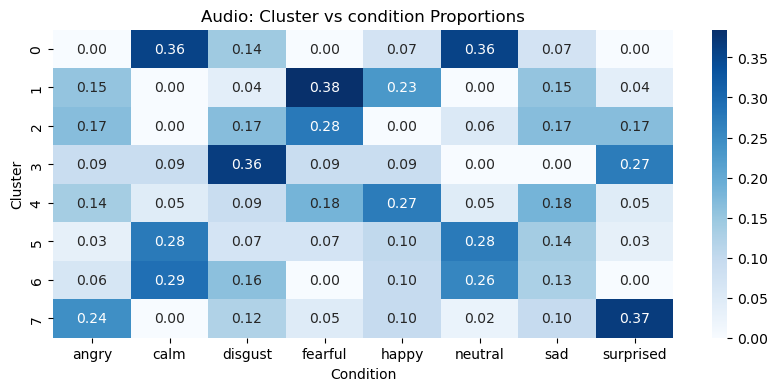

In [10]:
X_emo_audio, y_emo_audio = preprocess_data(audio_df, "condition")
df_out_audio = kmeans_clustering(audio_df, X_emo_audio, y_emo_audio)
plot_cluster_results(df_out_audio, "condition", "Audio")

Silhouette Score: 0.133
Adjusted Rand Index: 0.576


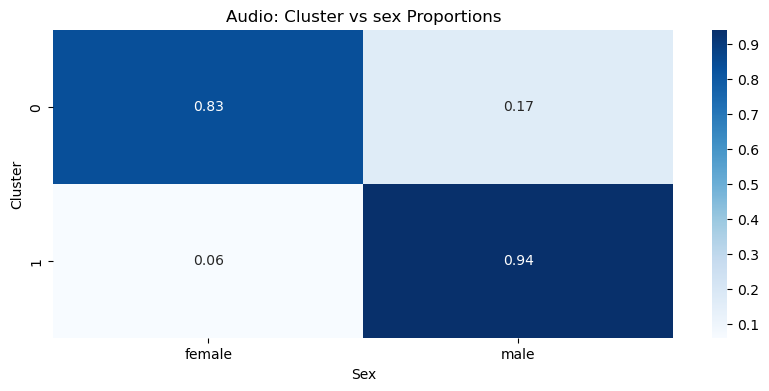

In [11]:
X_sex_audio, y_sex_audio = preprocess_data(audio_df, "sex")
df_out_audio = kmeans_clustering(audio_df, X_sex_audio, y_sex_audio)
plot_cluster_results(df_out_audio, "sex", "Audio")

### Insights?
🧐 Are clusters based on audio features better at separating emotions or sex, and why might that be?